#### Bitcoin next day price change prediction

Сидорчук Богдан КА-21

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

data = pd.read_csv("btc_price_data.csv")

In [2]:
data.head()

,timestamp,mark_price,index_price,estimated_settle_price,interest,funding,pay_time
0,1677865680,22418.8,22428.8,22392.0,0.01,-0.000679,0
1,1677865860,22412.1,22421.9,22396.4,0.01,-0.000651,0
2,1677865920,22417.8,22426.0,22397.6,0.01,-0.000625,0
3,1677924120,22339.3,22350.1,22353.4,0.01,0.004143,0
4,1677924180,22343.2,22354.3,22353.6,0.01,0.004130,0


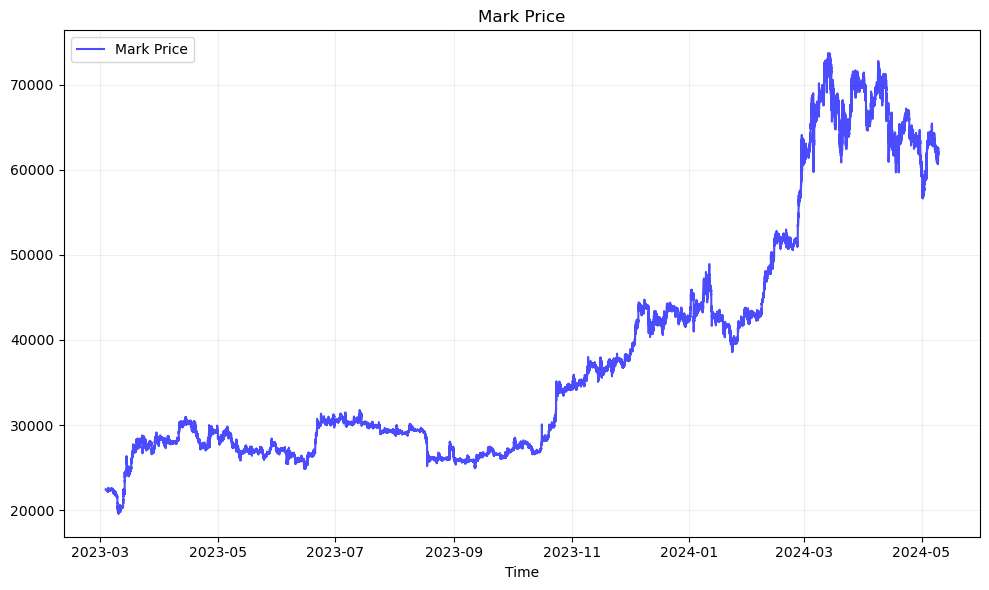

In [3]:
import matplotlib.pyplot as plt

def price_time_plot(data=data):
    df = data.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['mark_price'], label='Mark Price', color='blue', alpha=0.7)
    plt.xlabel('Time')
    plt.title('Mark Price')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

price_time_plot(data)

Створимо вектор міток (-1 для -5%, 0 ціна залишилась в діапазоні +-5%, 1 для +5%)

In [4]:
def create_labels(df = data):
    data = df.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data = data.sort_values(by='timestamp')
    df['target_label'] = 0
    closest_indices = []

    for i in range(len(data)):
        current_time = data['timestamp'].iloc[i]
        target_time = current_time + pd.Timedelta(hours=24)
        closest_index = data['timestamp'].searchsorted(target_time, side='left')
        
        if closest_index < len(data):
            closest_row = data.iloc[closest_index]
            closest_indices.append(closest_row.name)
            current_price = data['mark_price'].iloc[i]
            target_price = closest_row['mark_price']
            price_change = (target_price - current_price) / current_price
            
            if price_change >= 0.05:
                df.loc[i, 'target_label'] = 1
            elif price_change <= -0.05:
                df.loc[i, 'target_label'] = -1    

create_labels()

In [5]:
label_counts = data['target_label'].value_counts()
print(label_counts)

target_label
 0    578363
 1     26908
-1     12368
Name: count, dtype: int64


Для подальшої оцінки моделі врахуємо, що набір даних є незбалансованим по класам

In [6]:
print(data[['mark_price','index_price','estimated_settle_price']].head())

   mark_price  index_price  estimated_settle_price
0     22418.8      22428.8                 22392.0
1     22412.1      22421.9                 22396.4
2     22417.8      22426.0                 22397.6
3     22339.3      22350.1                 22353.4
4     22343.2      22354.3                 22353.6


Створимо нові ознаки для збереження інформації про зміни ознак у відносних одиницях

Спочатку обчислимо зміни у відсотках, далі розрахуємо середні значення, стандартні відхилення та коефіцієнт зміни у вікні 5 днів

In [7]:
data['mark_price_change'] = data['mark_price'].pct_change().fillna(0)
data['index_price_change'] = data['index_price'].pct_change().fillna(0)
data['estimated_settle_price_change'] = data['estimated_settle_price'].pct_change().fillna(0)

data['mark_price_change_mean_5'] = data['mark_price_change'].rolling(window=5).mean()
data['index_price_change_mean_5'] = data['index_price_change'].rolling(window=5).mean()
data['estimated_settle_price_change_mean_5'] = data['estimated_settle_price_change'].rolling(window=5).mean()

data['mark_price_change_std_5'] = data['mark_price_change'].rolling(window=5).std()
data['index_price_change_std_5'] = data['index_price_change'].rolling(window=5).std()
data['estimated_settle_price_change_std_5'] = data['estimated_settle_price_change'].rolling(window=5).std()

def calculate_slope(series):
    x = np.arange(len(series))
    slope, _ = np.polyfit(x, series, 1)
    return slope

data['mark_price_change_slope'] = data['mark_price_change'].rolling(window=5).apply(calculate_slope, raw=True)
data['index_price_change_slope'] = data['index_price_change'].rolling(window=5).apply(calculate_slope, raw=True)
data['estimated_settle_price_change_slope'] = data['estimated_settle_price_change'].rolling(window=5).apply(calculate_slope, raw=True)

In [8]:
data.columns

Index(['timestamp', 'mark_price', 'index_price', 'estimated_settle_price',
       'interest', 'funding', 'pay_time', 'target_label', 'mark_price_change',
       'index_price_change', 'estimated_settle_price_change',
       'mark_price_change_mean_5', 'index_price_change_mean_5',
       'estimated_settle_price_change_mean_5', 'mark_price_change_std_5',
       'index_price_change_std_5', 'estimated_settle_price_change_std_5',
       'mark_price_change_slope', 'index_price_change_slope',
       'estimated_settle_price_change_slope'],
      dtype='object')

Підготуємо дані для навчання та оцінки моделі

In [9]:
X = data[['mark_price_change', 'index_price_change', 
       'estimated_settle_price_change', 'mark_price_change_mean_5',
       'index_price_change_mean_5', 'estimated_settle_price_change_mean_5',
        'mark_price_change_std_5', 'index_price_change_std_5',
        'estimated_settle_price_change_std_5', 'mark_price_change_slope',
        'index_price_change_slope', 'estimated_settle_price_change_slope', 'funding']]
y = data['target_label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

split_index = int(0.95 * len(X))
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.iloc[3:]
y_train = y_train.iloc[3:]

In [10]:
# Розподіл по класам у тренувальному та тестовому наборі
label_counts = y_train.value_counts()
print(label_counts)
label_counts = y_test.value_counts()
print(label_counts)

target_label
 0    549832
 1     25646
-1     11276
Name: count, dtype: int64
target_label
 0    28528
 1     1262
-1     1092
Name: count, dtype: int64


Дата починаючи з якої буде робитись передбачення

In [11]:
pd.to_datetime(data[:split_index].iloc[-1]['timestamp'],unit='s')

Timestamp('2024-04-18 07:02:00')

Створимо модель CatBoost

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.001,
    depth=7,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42,
    class_weights=[0.4, 0.0102, 0.22]
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print(f"Accuracy: {accuracy}")
for i, accuracy in enumerate(class_accuracies):
    print(f'Class {i - 1} accuracy: {accuracy:.4f}')
print(f"F1-score: {f1score}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.5186840230555015
Class -1 accuracy: 0.6255
Class 0 accuracy: 0.5147
Class 1 accuracy: 0.5174
F1-score: 0.6321117552651789
Confusion Matrix:
[[  683   208   201]
 [ 2212 14682 11634]
 [    0   609   653]]


In [13]:
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Feature Importance': model.feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False)

print(feature_importance_df)

                                 Feature  Feature Importance
12                               funding           74.229426
7               index_price_change_std_5           13.016674
5   estimated_settle_price_change_mean_5            5.155157
8    estimated_settle_price_change_std_5            3.658267
2          estimated_settle_price_change            2.645013
6                mark_price_change_std_5            1.295462
0                      mark_price_change            0.000000
1                     index_price_change            0.000000
3               mark_price_change_mean_5            0.000000
4              index_price_change_mean_5            0.000000
9                mark_price_change_slope            0.000000
10              index_price_change_slope            0.000000
11   estimated_settle_price_change_slope            0.000000


In [24]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.001,
    depth=7,
    loss_function='MultiClass', 
    eval_metric='MultiClass',
    random_seed=42,
    class_weights=[0.4, 0.0108, 0.232]
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print(f"Accuracy: {accuracy}")
for i, accuracy in enumerate(class_accuracies):
    print(f'Class {i - 1} accuracy: {accuracy:.4f}')
print(f"F1-score: {f1score}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.5306327310407357
Class -1 accuracy: 0.5449
Class 0 accuracy: 0.5307
Class 1 accuracy: 0.5158
F1-score: 0.6443163500499167
Confusion Matrix:
[[  595   266   231]
 [ 1679 15141 11708]
 [    0   611   651]]


In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Feature Importance': model.feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False)

print(feature_importance_df)

                                 Feature  Feature Importance
12                               funding           74.064871
7               index_price_change_std_5           12.979045
5   estimated_settle_price_change_mean_5            5.250743
8    estimated_settle_price_change_std_5            3.677990
2          estimated_settle_price_change            2.637666
6                mark_price_change_std_5            1.389684
0                      mark_price_change            0.000000
1                     index_price_change            0.000000
3               mark_price_change_mean_5            0.000000
4              index_price_change_mean_5            0.000000
9                mark_price_change_slope            0.000000
10              index_price_change_slope            0.000000
11   estimated_settle_price_change_slope            0.000000
